In [54]:
# 처음에 VGG16 을 이용해서 훈련을 시작 하였으나 VGG16은 기본 (224, 224, 3) 인데
# 현재 cifar10은 (32, 32, 3) 이어서 매우 나쁜 훈련 결과가 나왔다...
# 그래서 MObileNet 으로 바꾸었다
# VGG16 보다는 나으나, 역시 훈련결과는 CNN 보다 양호 하지 않았다...
# 이번에는 Xception 을 이용하여 해보았다.

In [55]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

In [56]:
print(len(tfds.list_builders()))
print(tfds.list_builders())

1274
['abstract_reasoning', 'accentdb', 'aeslc', 'aflw2k3d', 'ag_news_subset', 'ai2_arc', 'ai2_arc_with_ir', 'amazon_us_reviews', 'anli', 'answer_equivalence', 'arc', 'asqa', 'asset', 'assin2', 'asu_table_top_converted_externally_to_rlds', 'austin_buds_dataset_converted_externally_to_rlds', 'austin_sailor_dataset_converted_externally_to_rlds', 'austin_sirius_dataset_converted_externally_to_rlds', 'bair_robot_pushing_small', 'bc_z', 'bccd', 'beans', 'bee_dataset', 'beir', 'berkeley_autolab_ur5', 'berkeley_cable_routing', 'berkeley_fanuc_manipulation', 'berkeley_gnm_cory_hall', 'berkeley_gnm_recon', 'berkeley_gnm_sac_son', 'berkeley_mvp_converted_externally_to_rlds', 'berkeley_rpt_converted_externally_to_rlds', 'big_patent', 'bigearthnet', 'billsum', 'binarized_mnist', 'binary_alpha_digits', 'ble_wind_field', 'blimp', 'booksum', 'bool_q', 'bot_adversarial_dialogue', 'bridge', 'bucc', 'c4', 'c4_wsrs', 'caltech101', 'caltech_birds2010', 'caltech_birds2011', 'cardiotox', 'cars196', 'cassava

In [57]:
data, info = tfds.load('cifar10', with_info=True)
print(info)

tfds.core.DatasetInfo(
    name='cifar10',
    full_name='cifar10/3.0.2',
    description="""
    The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.
    """,
    homepage='https://www.cs.toronto.edu/~kriz/cifar.html',
    data_dir='/home/ramius/tensorflow_datasets/cifar10/3.0.2',
    file_format=tfrecord,
    download_size=162.17 MiB,
    dataset_size=132.40 MiB,
    features=FeaturesDict({
        'id': Text(shape=(), dtype=string),
        'image': Image(shape=(32, 32, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=50000, num_shards=1>,
    },
    citation="""@TECHREPORT{Krizhevsky09learningmultiple,
        author = {Alex Krizhevsky},
        title = 

In [58]:
ds_train = data['train']
print(len(ds_train))

ds_train = ds_train.map(lambda x:(tf.image.resize(x['image'], (71, 71)), x['label']))
ds_train = ds_train.shuffle(10000).batch(50000)
batch = next(iter(ds_train))
print(batch[0].shape, batch[1].shape)

x_train, y_train = batch
print(x_train.shape, type(x_train))

50000
(50000, 71, 71, 3) (50000,)
(50000, 71, 71, 3) <class 'tensorflow.python.framework.ops.EagerTensor'>


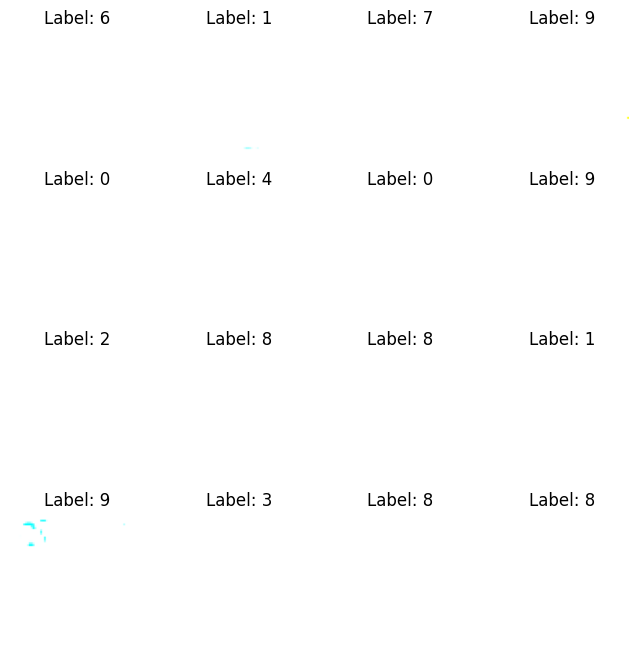

In [59]:
import matplotlib.pyplot as plt
import random

random_idx = np.random.randint(0, len(x_train), size=16)

plt.figure(figsize=(8, 8))
for i, idx in enumerate(random_idx):
    plt.subplot(4, 4, i+1)
    plt.imshow(x_train[idx])
    plt.title(f"Label: {y_train[idx]}")
    plt.axis("off")

plt.show()

# 이미 한번 사용한 것이라, 이미지가 정산적으로 출력 되지 않는다.... 


In [60]:
ds_test = data['test']
print(len(ds_test))

ds_test = ds_test.map(lambda x:(tf.image.resize(x['image'], (71, 71)), x['label']))
ds_test = ds_test.shuffle(2000).batch(10000)
batch = next(iter(ds_test))
print(batch[0].shape, batch[1].shape)
print(type(batch[0]), type(batch[1]))

x_test , y_test = batch
print(x_test.shape, y_test.shape)
print(type(x_test), type(y_test))

10000
(10000, 71, 71, 3) (10000,)
<class 'tensorflow.python.framework.ops.EagerTensor'> <class 'tensorflow.python.framework.ops.EagerTensor'>
(10000, 71, 71, 3) (10000,)
<class 'tensorflow.python.framework.ops.EagerTensor'> <class 'tensorflow.python.framework.ops.EagerTensor'>


In [61]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

gen = ImageDataGenerator(rotation_range=10, 
                         width_shift_range=0.1, 
                         height_shift_range=0.1, 
                         shear_range=0.1, 
                         zoom_range=0.1, 
                         horizontal_flip=True, 
                         fill_mode='nearest')

In [62]:
augment_ratio=1.5
augment_size= int(augment_ratio * x_train.shape[0])
print(augment_size)

# randidx = np.random.randint(0, x_train.shape[0], size= augment_size)
randidx = np.random.randint(x_train.shape[0], size=augment_size)

x_augmented = x_train[randidx].copy()
y_augmented = y_train[randidx].copy()
print(x_augmented.shape, y_augmented.shape)

flow_iterator = gen.flow(x_augmented, y_augmented,
                         batch_size=64, 
                         shuffle=False)

x_augmented_batch, y_augmented_batch = next(flow_iterator)
print(x_augmented_batch.shape, y_augmented_batch.shape)

x_train = np.concatenat( (x_train, x_augmented_batch) )
y_train = mp.concatenate( (y_train, y_augmented_batch) )
print(x_train.shape, y_train.shape)

75000


TypeError: Only integers, slices (`:`), ellipsis (`...`), tf.newaxis (`None`) and scalar tf.int32/tf.int64 tensors are valid indices, got array([26377, 16361, 29279, ...,  2463, 49087, 29476])

In [ ]:
from tensorflow.keras.utils import to_categorical

print(x_train.shape, type(x_train), y_train.shape, type(y_train))

x_train = np.array(x_train) / 255
x_test = np.array(x_test) /255

print(x_train.shape, type(x_train), y_train.shape, type(y_train))

y_train = to_categorical(np.array(y_train))
y_test = to_categorical(np.array(y_test))

(50000, 71, 71, 3) <class 'tensorflow.python.framework.ops.EagerTensor'> (50000,) <class 'tensorflow.python.framework.ops.EagerTensor'>
(50000, 71, 71, 3) <class 'numpy.ndarray'> (50000,) <class 'tensorflow.python.framework.ops.EagerTensor'>


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras.applications import VGG16, Xception
from tensorflow.keras.optimizers import Adam

base_model = Xception(weights='imagenet', include_top=False, input_shape=(71, 71, 3))
# base_model.summary()

model = Sequential()
model.add(base_model)

# model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
# model.add(Conv2D(32,(3, 3), activation='relu'))
# # model.add(MaxPooling2D(2, 2))
# model.add(Dropout(0.2))

# model.add(Conv2D(64, (3, 3), activation='relu'))
# model.add(Conv2D(64, (3, 3), activation='relu'))
# model.add(MaxPooling2D(2, 2))
# model.add(Dropout(0.2))

# model.add(Conv2D(128, (3, 3), activation='relu'))
# model.add(Conv2D(128, (3, 3), activation='relu'))
# model.add(MaxPooling2D(2, 2))
# model.add(Dropout(0.2))
# model.add(BatchNormalization())

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(10, activation='softmax'))

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ ?                      │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,861,480 (79.58 MB)

 Trainable params: 20,806,952 (79.37 MB)

 Non-trainable params: 54,528 (213.00 KB)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint('./model/cifar100_model.keras', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min')
reduce_rl = ReduceLROnPlateau(monitor='val_loss', patience=5, verbose=1, mode='min')

In [ ]:
from datetime import datetime

model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(2e-5), metrics=['acc'])

start_time = datetime.now()

history = model.fit(x_train, y_train, batch_size=32, epochs=30,
                 validation_split=0.2, callbacks=[stopping, checkpoint, reduce_rl])

end_time = datetime.now()

print('elapsed time => ', end_time-start_time)

Epoch 1/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 712ms/step - acc: 0.5157 - loss: 1.4107
Epoch 1: val_loss improved from inf to 0.47201, saving model to ./model/cifar100_model.keras
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 966s 762ms/step - acc: 0.5158 - loss: 1.4104 - val_acc: 0.8443 - val_loss: 0.4720 - learning_rate: 2.0000e-05
Epoch 2/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 660ms/step - acc: 0.8581 - loss: 0.4315
Epoch 2: val_loss improved from 0.47201 to 0.40557, saving model to ./model/cifar100_model.keras
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 883s 706ms/step - acc: 0.8581 - loss: 0.4315 - val_acc: 0.8692 - val_loss: 0.4056 - learning_rate: 2.0000e-05
Epoch 3/30
 119/1250 ━━━━━━━━━━━━━━━━━━━━ 86:29:42 275s/step - acc: 0.9168 - loss: 0.2581

KeyboardInterrupt: 

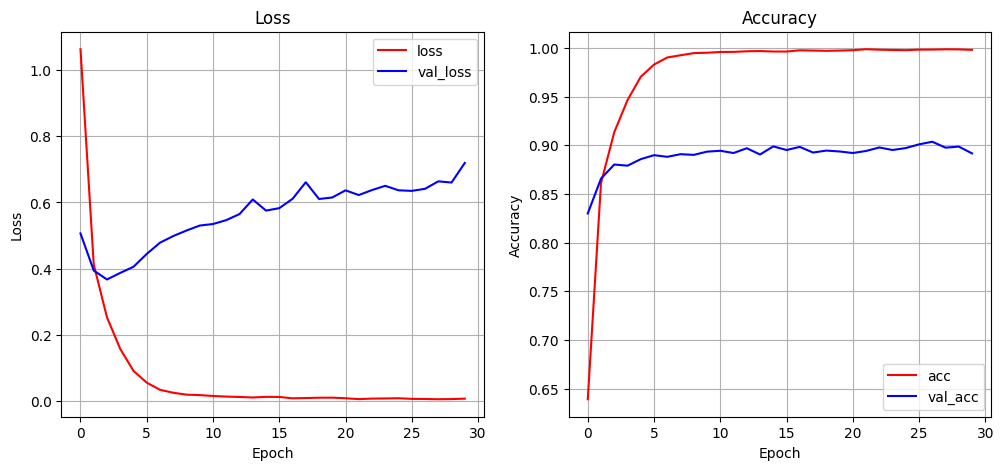

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='loss', color='red')
plt.plot(history.history['val_loss'], label='val_loss', color='blue')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(history.history['acc'], label='acc', color='red')
plt.plot(history.history['val_acc'], label='val_acc', color='blue')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

model.evaluate(x_test, y_test)

pred_ys = model.predict(x_test)
print(pred_ys[0], np.argmax(pred_ys[0]))


plt.figure(figsize=(10, 10))
sns.set_style('whitegrid')
cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(pred_ys, axis=-1))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
# plt.legend()
# plt.grid()

plt.show()


InvalidArgumentError: Graph execution error:

Detected at node sequential_1/flatten_1/Reshape defined at (most recent call last):
  File "c:\Users\euiso\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main

  File "c:\Users\euiso\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code

  File "C:\Users\euiso\AppData\Roaming\Python\Python310\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\euiso\AppData\Roaming\Python\Python310\site-packages\traitlets\config\application.py", line 1053, in launch_instance

  File "C:\Users\euiso\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelapp.py", line 737, in start

  File "C:\Users\euiso\AppData\Roaming\Python\Python310\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "c:\Users\euiso\AppData\Local\Programs\Python\Python310\lib\asyncio\base_events.py", line 600, in run_forever

  File "c:\Users\euiso\AppData\Local\Programs\Python\Python310\lib\asyncio\base_events.py", line 1896, in _run_once

  File "c:\Users\euiso\AppData\Local\Programs\Python\Python310\lib\asyncio\events.py", line 80, in _run

  File "C:\Users\euiso\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 524, in dispatch_queue

  File "C:\Users\euiso\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 513, in process_one

  File "C:\Users\euiso\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 418, in dispatch_shell

  File "C:\Users\euiso\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 758, in execute_request

  File "C:\Users\euiso\AppData\Roaming\Python\Python310\site-packages\ipykernel\ipkernel.py", line 426, in do_execute

  File "C:\Users\euiso\AppData\Roaming\Python\Python310\site-packages\ipykernel\zmqshell.py", line 549, in run_cell

  File "C:\Users\euiso\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3024, in run_cell

  File "C:\Users\euiso\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3079, in _run_cell

  File "C:\Users\euiso\AppData\Roaming\Python\Python310\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner

  File "C:\Users\euiso\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3284, in run_cell_async

  File "C:\Users\euiso\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3466, in run_ast_nodes

  File "C:\Users\euiso\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3526, in run_code

  File "C:\Users\euiso\AppData\Local\Temp\ipykernel_23664\966163082.py", line 3, in <module>

  File "c:\Users\euiso\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\euiso\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 441, in evaluate

  File "c:\Users\euiso\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 170, in one_step_on_iterator

  File "c:\Users\euiso\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 158, in one_step_on_data

  File "c:\Users\euiso\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 84, in test_step

  File "c:\Users\euiso\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\euiso\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\layer.py", line 825, in __call__

  File "c:\Users\euiso\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\euiso\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\ops\operation.py", line 48, in __call__

  File "c:\Users\euiso\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\utils\traceback_utils.py", line 156, in error_handler

  File "c:\Users\euiso\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\models\sequential.py", line 202, in call

  File "c:\Users\euiso\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\models\functional.py", line 195, in call

  File "c:\Users\euiso\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\ops\function.py", line 151, in _run_through_graph

  File "c:\Users\euiso\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\models\functional.py", line 579, in call

  File "c:\Users\euiso\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\euiso\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\layer.py", line 825, in __call__

  File "c:\Users\euiso\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\euiso\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\ops\operation.py", line 48, in __call__

  File "c:\Users\euiso\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\utils\traceback_utils.py", line 156, in error_handler

  File "c:\Users\euiso\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\reshaping\flatten.py", line 54, in call

  File "c:\Users\euiso\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\ops\numpy.py", line 4522, in reshape

  File "c:\Users\euiso\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\backend\tensorflow\numpy.py", line 1618, in reshape

Only one input size may be -1, not both 0 and 1
	 [[{{node sequential_1/flatten_1/Reshape}}]] [Op:__inference_one_step_on_iterator_306023]